# STAT 4243 Project 5 (Sports Analytics)

### Introduction

The goal of the project is to find out what is the cheapest team needed to qualify for Champions League in La Liga

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor

from verstack import FeatureSelector
from featurewiz import featurewiz

from gurobipy import Model, GRB, quicksum, max_

Imported 0.2.03 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



### Data Processing 

The data was webscraped from fbref.com and transfermarkt.com. The webscrapping and cleaning of the data was done in a python script that is attached in the repo, and the cleaned data has been exported to csv. To that end, we are just reading in the csv here and merging them as needed.

In [2]:
post_2017_df = pd.read_csv('../data/post_2017_fbref_data.csv',encoding= 'unicode_escape').iloc[:,1:]
pre_2017_df = pd.read_csv('../data/pre_2017_fbref_data.csv',encoding= 'unicode_escape').iloc[:,1:]
xfer_df = pd.read_csv('../data/xfer_data.csv',encoding= 'unicode_escape').iloc[:,1:]

new_col_names = {"year":"Season"}
xfer_df = xfer_df.rename(columns=new_col_names)

player_stat = pd.read_csv('../data/player_stats.csv', encoding= 'unicode_escape').iloc[:,1:]
new_col_names = {"Annual Wages":"Wage"}
player_stat = player_stat.rename(columns=new_col_names)

In [3]:
pre_2017_df = pre_2017_df.append(post_2017_df[pre_2017_df.columns.to_list()])
pre_2017_df = pd.merge(pre_2017_df,xfer_df,on=['Season','team'])

### EDA

As the top 4 teams of Laliga is automatically qualified to the Champions League. We are splitting the data set into two groups, top 4 and non top 4 for each season. The aim of the EDA is to determine what would be a good cut-off point for points needed to qualify for the champions league.

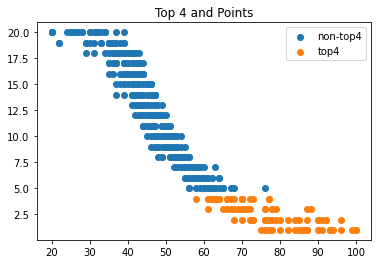

In [4]:
top_4 = pre_2017_df[pre_2017_df['rank']<=4]
non_top_4 = pre_2017_df[pre_2017_df['rank']>4]

plt.scatter(non_top_4['points'],non_top_4['rank'], label=f'non-top4')
plt.scatter(top_4['points'], top_4['rank'], label=f'top4')

plt.rcParams.update({'figure.figsize':(6.4,4.8), 'figure.dpi':100})
plt.title('Top 4 and Points')
plt.legend()
plt.show()

From a quick observation, there has been instances where teams has las than 60 points and still qualified for the champions leauge, but there is also a high probability it doesn't if it has less than 60 points. A good cut-off point would be in between 60-70 points. After testing out a few possible threshold, we have reached that 66 points is a good threshold. To justify this a contingency table has been provided below.

In [5]:
pre_2017_df['Top4']= ['Top4' if i<=4 else 'Not_Top4' for i in pre_2017_df['rank']]
pre_2017_df['66pts']= ['GE66' if i>=66 else 'LT66' for i in pre_2017_df['points']]
pre_2017_df['log(expenditure)'] = [math.log(i) if i>0 else 0 for i in pre_2017_df['expenditure']]

In [6]:
data_crosstab = pd.crosstab(pre_2017_df['Top4'],pre_2017_df['66pts'])

data_crosstab

66pts,GE66,LT66
Top4,,
Not_Top4,3,349
Top4,76,12


To reinforce the contingency table, a conditional probability was calculated. The probability of being in top 4 given that a team has 66 points in the last 22 seasons was 96.2%, which reinforces that 66 points is a good cut-off.

In [7]:
len(pre_2017_df[(pre_2017_df['points']>=66) & (pre_2017_df['rank']<=4)])/len(pre_2017_df[pre_2017_df['points']>=66])

0.9620253164556962

A scatterplot was plotted below to show the relationship between the spending and points. As we can see that there is a positive linear relationship between spending and points; the more one spends the more points a team is likely to gain more than 66 points and hence be in the top 4.

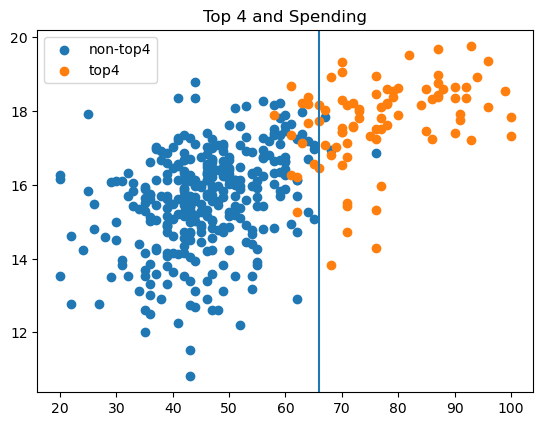

In [8]:
top_4 = pre_2017_df[(pre_2017_df['rank']<=4) & (pre_2017_df['expenditure']>0)]
non_top_4 = pre_2017_df[(pre_2017_df['rank']>4) & (pre_2017_df['expenditure']>0)]

plt.scatter(non_top_4['points'], non_top_4['log(expenditure)'], label=f'non-top4')
plt.scatter(top_4['points'], top_4['log(expenditure)'], label=f'top4')
plt.axvline(x=66)

plt.rcParams.update({'figure.figsize':(6.4,4.8), 'figure.dpi':100})
plt.title('Top 4 and Spending')
plt.legend()
plt.show()

### Feature Selection

As there is not sufficient data points and a lot of match statistics (features), we need to perform feature selection here. And as we have determined that 66 points is a good threshold, moving foward we redefine the objective as being able to achieve 66 points or more. As such we have split the data into two groups, teams with more than 66 points or less.

In [9]:
top_4 = post_2017_df[post_2017_df['points']>=66]
non_top_4 = post_2017_df[post_2017_df['points']<66]

top_4_stats = top_4.iloc[:,3:]
non_top_4_stats = non_top_4.iloc[:,3:]

Before we use any modules, we decided to see if there is any significant different between the two groups for each of the features. From the t-test ran below, it has determined a list of features that are statistically significant between both groups. These are features that we think we should focus on later when trying to maximize the points, as t-test shows that these are the features that are likey to be seperating between the two groups (teams with more than 66 points and team with less).

In [10]:
stat = []
p_values = []
for col in top_4_stats.columns:
    
    group1 = top_4_stats[col].array
    group2 = non_top_4_stats[col].array
    p = stats.ttest_ind(a=group1, b=group2, equal_var=True).pvalue
    stat.append(col)
    p_values.append(p)
    #print("\n{} T-Score:".format(col))
    #print(stats.ttest_ind(a=group1, b=group2, equal_var=False))
    
    

d = {'stats':stat,'p-value':p_values}
p_values = pd.DataFrame(d).sort_values('p-value')

pd.set_option('display.float_format',  '{:,}'.format)

desirable_stats = p_values[p_values['p-value']<0.05]
sig_diff_features = desirable_stats['stats'].to_list()

desirable_stats

,stats,p-value
7,avg_points,6.863310567703631e-24
6,points,6.998265832882778e-24
0,wins,2.809526808418372e-23
5,goals_diff,2.9193287070391623e-21
2,losses,1.3790066034263885e-18
10,x_goals_diff,3.8311851958412493e-16
3,goals_for,3.1033228677719618e-15
15,att_pass,9.011438723075842e-15
14,cmp_pass,9.229218140270689e-15
12,SoT,9.903185482439278e-14


In [11]:
### POSSIBLE BOX PLOTS
#group1 = top_4_stats['goals_diff']
#group2 = non_top_4_stats['goals_diff']

#data = [group1,group2]
#plt.boxplot(data)
#plt.show()

#### Featurewiz (all features)

The package Featurewiz has two benefits. It first determines which are the highly correlated variables, and then selects the list of variables that doesn't have high correlation. The correlaiton threshold was set at 0.7 here.

The second benefit is that after removing the highly correlated variables, it uses xgBoost to do feature selection, before finally returning a subset of the features from the first step.

For us, we have decided to keep both list of features. The one suggested by it and the other list which has eliminated all the highly correlated features.

In [12]:
post_2017_stats = post_2017_df.iloc[:,8:] # DROPPED W/L/D/GOAL DIFF/LINEAR RELATED
features1, features2, target = post_2017_stats.iloc[:,:1],post_2017_stats.iloc[:,3:], post_2017_stats.iloc[:,1] 

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Correlation Limit = 0.7
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (100, 26)
#### Single_Label Regression problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
        No variables were removed since no ID or

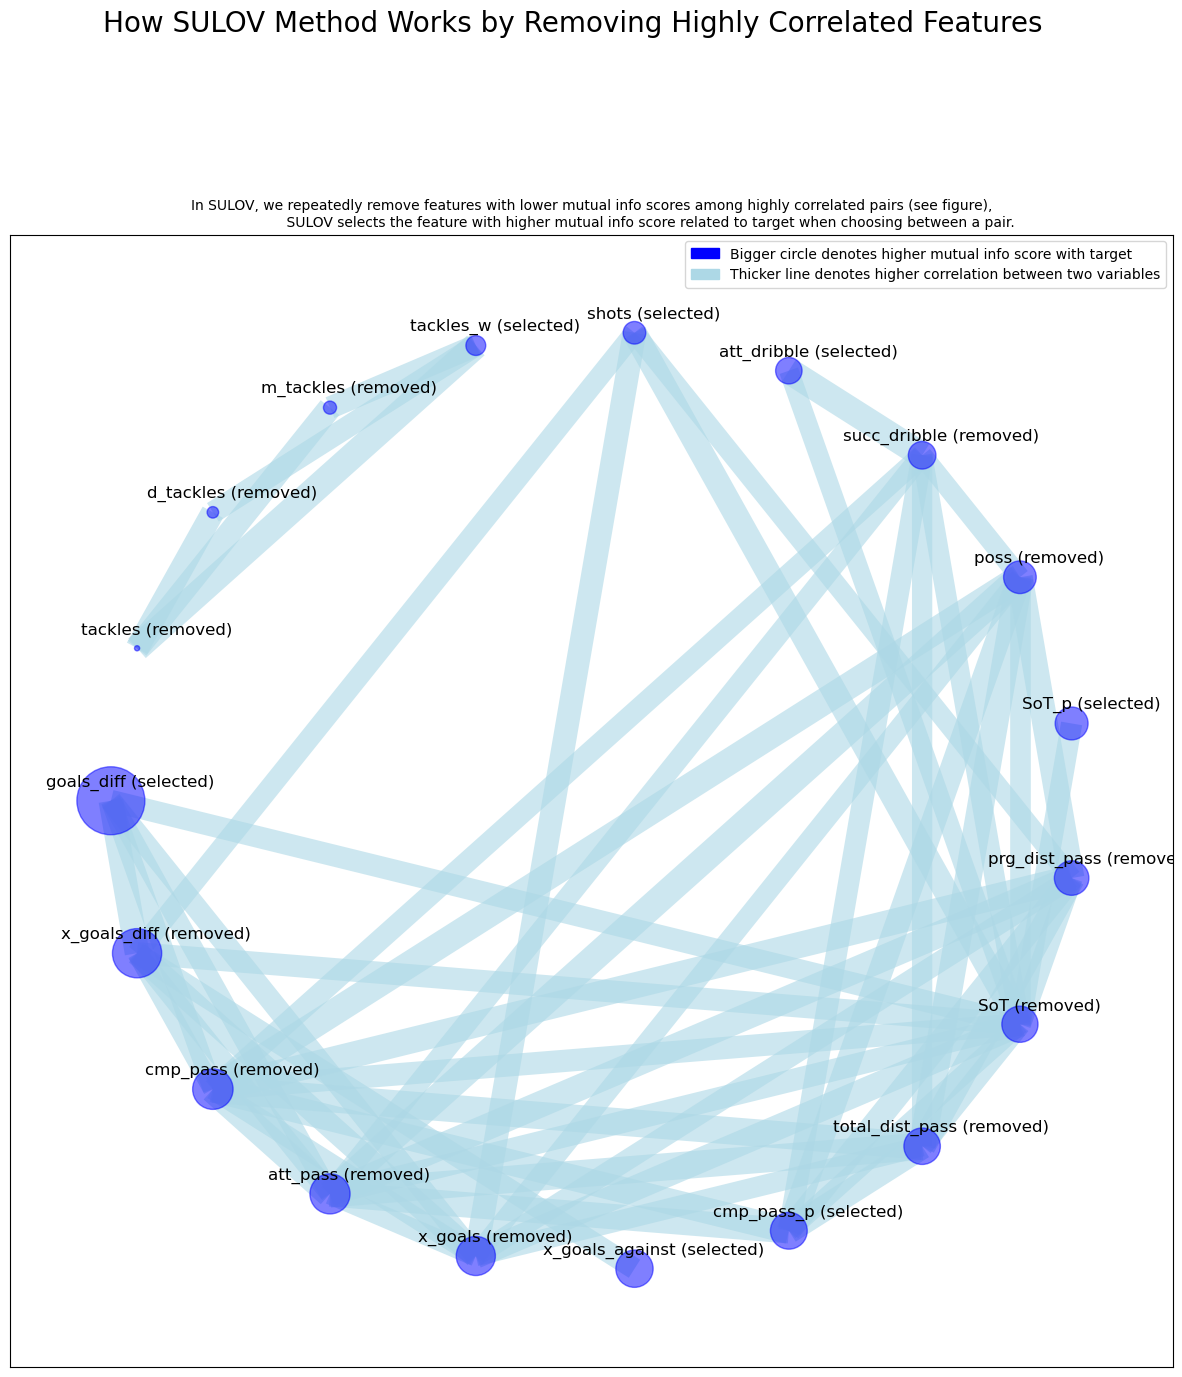

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 13
Final list of selected 13 vars after SULOV = ['a_tackles', 'block_p', 'block_s', 'clearance', 'errors', 'intercepts', 'goals_diff', 'x_goals_against', 'cmp_pass_p', 'SoT_p', 'att_dribble', 'shots', 'tackles_w']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 13 
    Taking top 6 features per iteration...
    XGBoost version using 1.7.1 as tree method: hist
Number of booster rounds = 100
        using 13 variables...
            selecting 5 features in this iteration
            Time taken for regular XGBoost feature selec

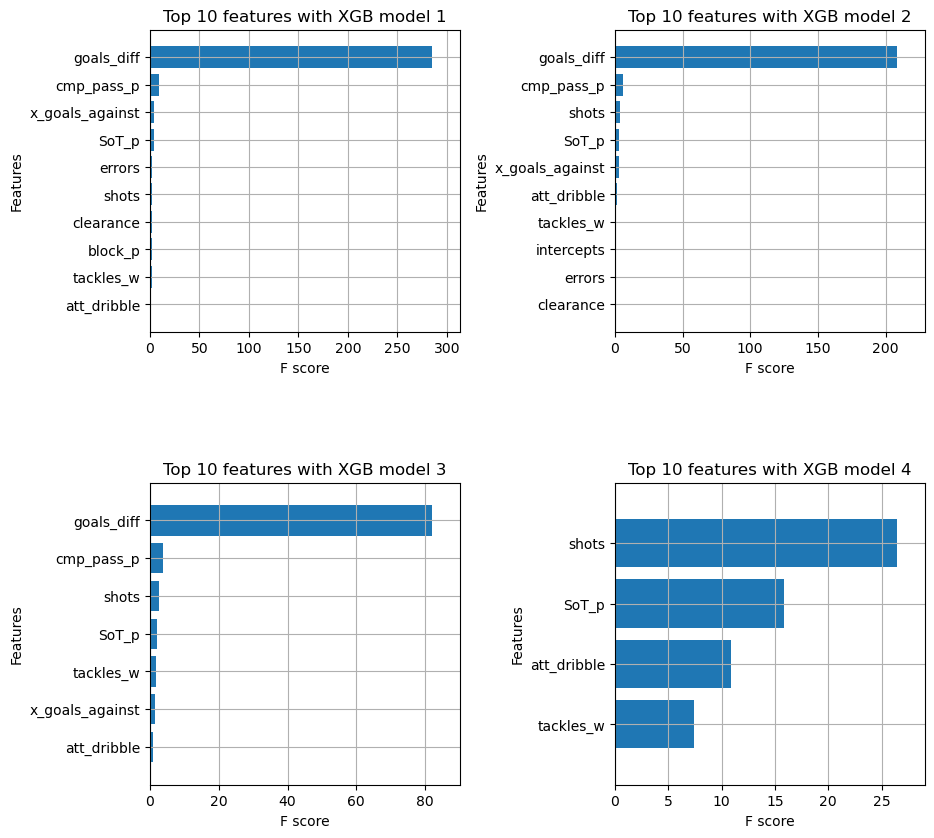

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 6 important features:
['goals_diff', 'cmp_pass_p', 'x_goals_against', 'SoT_p', 'errors', 'shots']
Total Time taken for featurewiz selection = 2 seconds
Output contains a list of 6 important features and a train dataframe


In [13]:
# USING FEATUREWIZ TO SELECT FEATURES
data = pd.merge(features1,features2,left_index=True,right_index=True)
data = pd.merge(data,target,left_index=True,right_index=True)

features, train = featurewiz(data,'points',corr_limit=0.7,verbose=2,sep=",",header=0,test_data="",feature_engg="",category_encoders="")

In [14]:
fw_sugg_features = features
fw_uncorr_features = ['a_tackles', 'block_p', 'block_s', 'clearance', 'errors', 'intercepts', 'goals_diff',
                      'x_goals_against', 'cmp_pass_p', 'SoT_p', 'att_dribble', 'shots', 'tackles_w']

#### FeatureSelector (All Features)

Using the list of features that has low correlation featurewiz has provided, we feed it into another module called FeatureSelector, which will take a subset of the lowly correlated features. The idea is to compare the features suggested by featurewiz and FeatureSelector, because they both use different methods to find a subset from the lowly correlated features.

In [15]:
# FIRST FEATURE SELECTION WITHOUT LOOKING AT SIG DIFF BETWEEN TWO GROUPS
FS = FeatureSelector(objective = 'regression',auto=True)
fs_sugg_features = FS.fit_transform(post_2017_stats[fw_uncorr_features],target)
# As we expect the final algorithm down the way to be linear, it was more relevant to select features that would work in linear model.
#FS = FeatureSelector(objective = 'regression', default_model_linear=True)
 # IMPORT FEATURES TO PREDICT POINTS


 * Initiating FeatureSelector

   - Comparing LinearRegression and RandomForest for feature selection

   - Running feature selection with Ridge()
     . Experiments are carried out on complete dataset

   - Running feature selection with RandomForestRegressor(max_depth=2, n_estimators=50)
     . Experiments are carried out on complete dataset

   - Scoring selected feats from linear and RF models by: LGBMRegressor()

     .. RFE by linear model cv-score       : -8.52703
     .. linear model n selected features   : 5

     .. RFE by RandomForest model cv-score : -9.10893
     .. RF model n selected features       : 13

     . Keeping feats from RFE with linear model 
 ---------------------------------------------------------------------------
     . Selected 5 features from 13

Time elapsed for fit_transform execution: 6.76421 seconds


In [16]:
fs_sugg_features = fs_sugg_features.columns.to_list()
possible_features = {'fs':fs_sugg_features,'fw':fw_sugg_features}

#### FeatureWiz (Statistically Significant Features)

Similar to the two sub-sections above, we will use FeatureWiz to provide a list of uncorrelated features and a list of suggested features. The difference here is that we are only feeding in the features that was previously determined as statistically significant from the t-test.

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Correlation Limit = 0.7
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (100, 17)
#### Single_Label Regression problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
        No variables were removed since no ID or

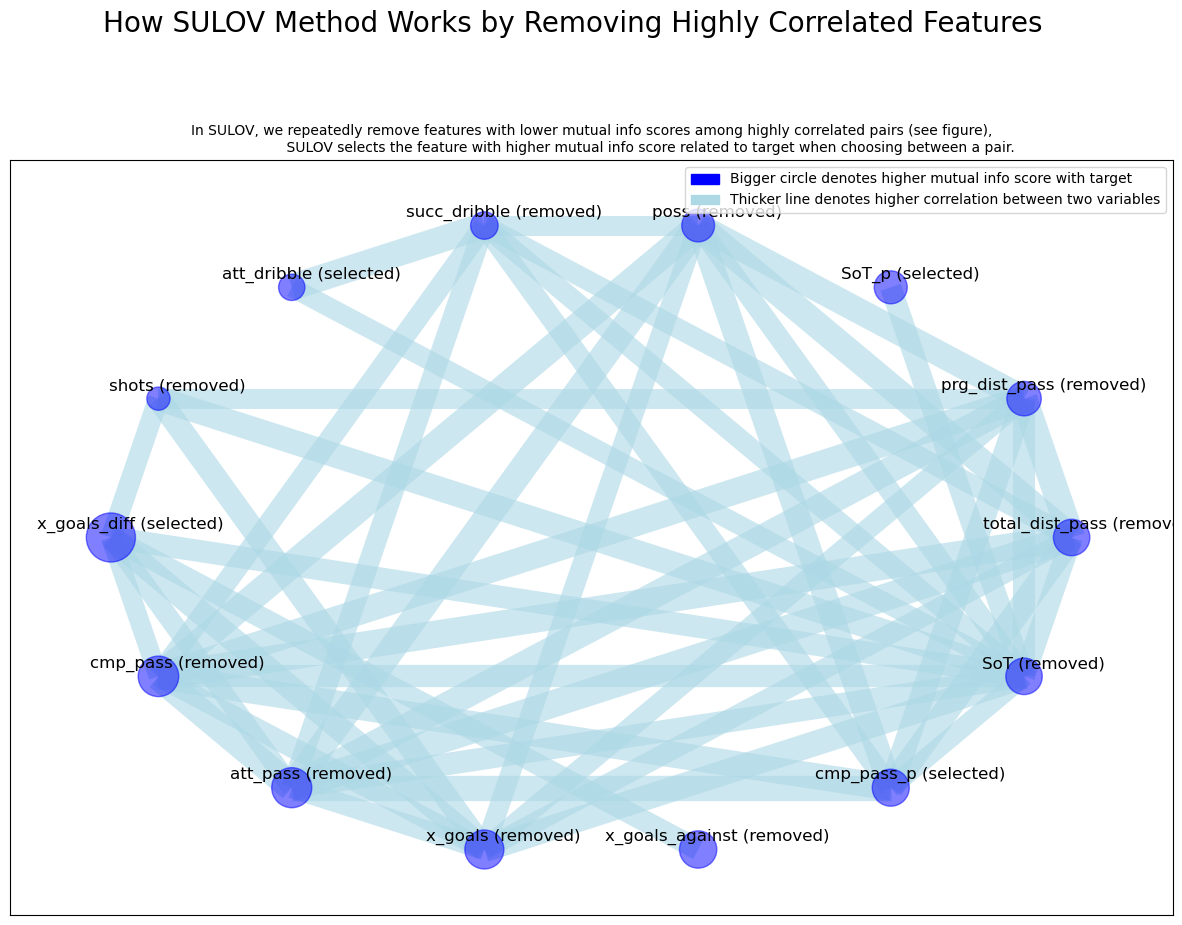

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 6
Final list of selected 6 vars after SULOV = ['a_tackles', 'clearance', 'x_goals_diff', 'cmp_pass_p', 'SoT_p', 'att_dribble']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 6 
    Taking top 4 features per iteration...
    XGBoost version using 1.7.1 as tree method: hist
Number of booster rounds = 100
        using 6 variables...
            selecting 3 features in this iteration
            Time taken for regular XGBoost feature selection = 0 seconds
        using 4 variables...
            selecting 2 features in this it

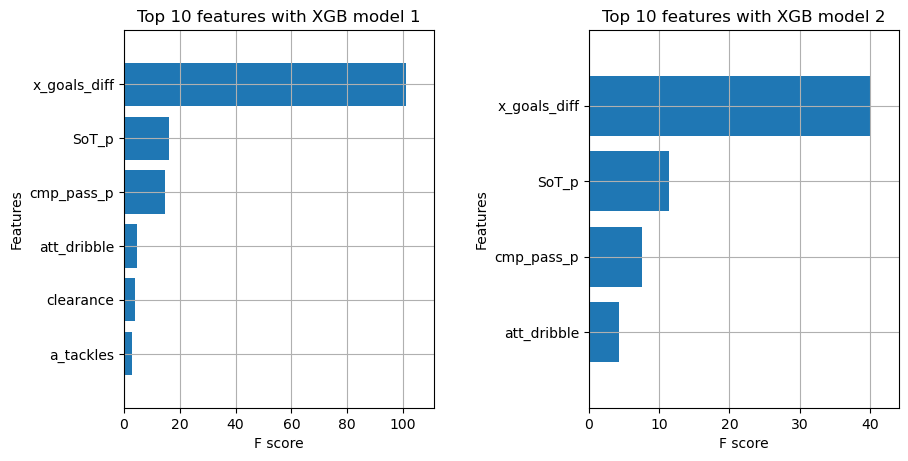

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 3 important features:
['x_goals_diff', 'SoT_p', 'cmp_pass_p']
Total Time taken for featurewiz selection = 2 seconds
Output contains a list of 3 important features and a train dataframe


In [17]:
sig_diff_features_df = post_2017_df[sig_diff_features[1:2] + sig_diff_features[5:6] + sig_diff_features[7:11] + sig_diff_features[12:]]

features, train = featurewiz(sig_diff_features_df,'points',corr_limit=0.7,verbose=2,sep=",",header=0,test_data="",feature_engg="",category_encoders="")

In [18]:
fw_sugg_sig_diff_features = features
fw_uncorr_sig_diff_features = ['a_tackles', 'clearance', 'x_goals_diff', 'cmp_pass_p', 'SoT_p', 'att_dribble']

#### FeatureSelector (Statistically Significant)

Likewise, we are using FeatureSelector to select a subset form the statistically significant features

In [19]:
target = sig_diff_features_df.iloc[:,0]
X_sig_diff = sig_diff_features_df[fw_uncorr_sig_diff_features]

FS = FeatureSelector(objective = 'regression', auto=True)
fs_sugg_sig_diff_features = FS.fit_transform(X_sig_diff,target)
fs_sugg_sig_diff_features


 * Initiating FeatureSelector

   - Comparing LinearRegression and RandomForest for feature selection

   - Running feature selection with Ridge()
     . Experiments are carried out on complete dataset

   - Running feature selection with RandomForestRegressor(max_depth=2, n_estimators=50)
     . Experiments are carried out on complete dataset

   - Scoring selected feats from linear and RF models by: LGBMRegressor()

     .. RFE by linear model cv-score       : -9.68962
     .. linear model n selected features   : 5

     .. RFE by RandomForest model cv-score : -9.52612
     .. RF model n selected features       : 6

     . Keeping feats from RFE with RF model 
 ---------------------------------------------------------------------------
     . Selected 6 features from 6

Time elapsed for fit_transform execution: 0.93976 seconds


,a_tackles,clearance,x_goals_diff,cmp_pass_p,SoT_p,att_dribble
0,84.0,526.0,30.7,87.2,37.7,780.0
1,81.0,467.0,27.9,85.9,34.6,747.0
2,67.0,649.0,19.9,78.9,33.2,600.0
3,71.0,603.0,5.1,82.4,32.3,588.0
4,79.0,777.0,10.2,80.8,35.8,655.0
...,...,...,...,...,...,...
95,76.0,820.0,-0.6,74.9,33.7,611.0
96,64.0,777.0,-7.6,69.7,31.8,608.0
97,60.0,942.0,-7.1,75.3,28.8,622.0
98,60.0,713.0,-32.0,80.0,29.4,714.0


In [20]:
fs_sugg_sig_diff_features = fs_sugg_sig_diff_features.columns.to_list()
possible_features['fw_sig']=fw_sugg_sig_diff_features
possible_features['fs_sig']=fs_sugg_sig_diff_features

#FS = FeatureSelector(objective = 'regression', default_model_linear=True)
 # IMPORT FEATURES TO PREDICT POINTS

In [21]:
possible_features

{'fs': ['block_s', 'clearance', 'goals_diff', 'x_goals_against', 'cmp_pass_p'],
 'fw': ['goals_diff',
  'cmp_pass_p',
  'x_goals_against',
  'SoT_p',
  'errors',
  'shots'],
 'fw_sig': ['x_goals_diff', 'SoT_p', 'cmp_pass_p'],
 'fs_sig': ['a_tackles',
  'clearance',
  'x_goals_diff',
  'cmp_pass_p',
  'SoT_p',
  'att_dribble']}

#### Model Training

After gathering 4 different list of features that we could use, we will now feed these different subset into LazyPredictor. LazyPredictor essentially fits and trains the data on many different kinds of models to allow us to see which model we should use and possibly which subset of features we should use to maximize our points.

In [22]:
def train(data, features, target):
    features = data[features]
    X_train, X_test,y_train, y_test = train_test_split(features, target, test_size=.2, random_state=42)# fit all models
    reg = LazyRegressor(predictions=True)
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    
    return models

In [23]:
for key in possible_features:
    features = possible_features.get(key)
    possible_features[key]=train(post_2017_stats,features,target)
    


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 23.23it/s]


In [24]:
possible_features['fs']
possible_features['fs_sig']
possible_features['fw']
possible_features['fw_sig']

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
AdaBoostRegressor,0.7490241828569979,0.7886519434585245,7.911129604139081,0.12108325958251953
KNeighborsRegressor,0.7128369536770478,0.7581784873069877,8.462269199216012,0.01598668098449707
Lasso,0.7115501926627359,0.7570948990844092,8.481207477204034,0.015622854232788086
RANSACRegressor,0.7091355756181013,0.7550615373626116,8.516631646058975,0.039914846420288086
HuberRegressor,0.7090492158250439,0.7549888133263527,8.51789587760384,0.027045726776123047
RandomForestRegressor,0.7066876503786377,0.7530001266346422,8.55239469388545,0.2112102508544922
LarsCV,0.7034031526142841,0.7502342337804497,8.600146041561146,0.015619277954101562
LassoLarsCV,0.7034031526142841,0.7502342337804497,8.600146041561146,0.023979902267456055
LassoCV,0.7029953360862956,0.7498908093358279,8.606056550964828,0.09371495246887207


From the results above, we have determined to use these features as our main regressor for points. And since these are our main regressors these are the features that we would want to focus on in order to achieve our objective of reaching more than 66 points and in turn qualify for the champions league.

### Linear Optimization

Now that we have determined which are the important features that help to gain most points, we now focus on the objective of finding the minimum cost needed.

The idea here is to minimize the cost function, which is the wages of the player under some constraints. The constraints include having n amount of goalkeeper, defender, midfielder, and forward. More importantly, the key constraints would be to achieve a minimum threshold for each of the important features we have selected above.

For feature 1, our minimum threshold is
For feature 2, our minimum threshold is 
For feature 3, our minimum threshold is 
For feature 4, our minimum threshold is 
For feature 5, our minimum threshold is 

In [25]:
indices = player_stat.Player
cost = dict(zip(indices,player_stat.Wage))
player_position = list(zip(player_stat.Player,player_stat.Pos))
player_map = list(player_stat.Player)

m = Model()
y = m.addVars(player_stat.Player,vtype=GRB.BINARY,name='y')
m.setObjective(quicksum(cost[i]*y[i] for i in indices), GRB.MINIMIZE)

m.addConstr(quicksum([y[i] for i, position in player_position if position=='GK'])==1)

m.addConstr(quicksum([y[i] for i, position in player_position if position=='DF'])>=3)
m.addConstr(quicksum([y[i] for i, position in player_position if position=='DF'])<=5)

m.addConstr(quicksum([y[i] for i, position in player_position if position=='MF'])>=3)
m.addConstr(quicksum([y[i] for i, position in player_position if position=='MF'])<=5)

m.addConstr(quicksum([y[i] for i, position in player_position if position=='FW'])>=1)
m.addConstr(quicksum([y[i] for i, position in player_position if position=='FW'])<=3)

m.addConstr(quicksum(y[i] for i in indices)==11)

### ADD CONSTRAINT ON WHAT TYPE OF STATISTICS WE WANT TO HIT

m.optimize()

r = pd.DataFrame()

for v in m.getVars():
    if v.x > 1e-6:
        r = r.append(player_stat.iloc[v.index][['Player','Pos','Wage']])
        print(v.varName)
        
print('Cost:', m.objVal)

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Celeron(R) N4020 CPU @ 1.10GHz, instruction set [SSE2]
Thread count: 2 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 8 rows, 533 columns and 1557 nonzeros
Model fingerprint: 0xc1165a8e
Variable types: 0 continuous, 533 integer (533 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+04, 3e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 4.168000e+07
Presolve removed 8 rows and 533 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.11 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 1.38e+06 4.168e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.380000000000e+06, best bound 1.380000000000

In [26]:
r

,Player,Pos,Wage
18,Dani Alves,DF,"155,000.0"
44,Barbero,FW,"155,000.0"
51,Ãlvaro Bastida,MF,"60,000.0"
94,Chapela,MF,"40,000.0"
213,Luis HernÃ¡ndez,DF,"140,000.0"
222,Iglesias,DF,"155,000.0"
247,JutglÃ,FW,"130,000.0"
442,Isma Ruiz,MF,"80,000.0"
463,Rui Silva,GK,"155,000.0"
480,Tachi,DF,"155,000.0"


### IF THERE IS TIME:
WE COULD GET THE AGGREGATED STATISTICS OF THE 11 PLAYERS AND PUT IT INTO ONE OF THE MODELS SUGGESTED BY LAZYPREDICTOR TO SEE IF THIS TEAM WILL REACH THE MINIMUM OF 66 POINTS.